<a href="https://colab.research.google.com/github/HarshitGoyal-1102/CoreCodeebot/blob/main/Advanced_Image_Denoising_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Model built successfully.
Model initialized.
Loading images from: /content/drive/MyDrive/train
Starting training...
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - loss: 0.0937 - mean_absolute_error: 0.2495 - val_loss: 0.1021 - val_mean_absolute_error: 0.2726
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0381 - mean_absolute_error: 0.1588 - val_loss: 0.0585 - val_mean_absolute_error: 0.2000
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0310 - mean_absolute_error: 0.1412 - val_loss: 0.0545 - val_mean_absolute_error: 0.1924
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.0256 - mean_absolute_error: 0.1273 - val_loss: 0.0443 - val_mean_absolute_error: 0.1638
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0208 - mean_absolute_error: 0.1151 - val_loss: 0.0374 - val_mean_absolute_error: 0.1418
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0170 - mean_absolute_error: 0.1033 - val_lo

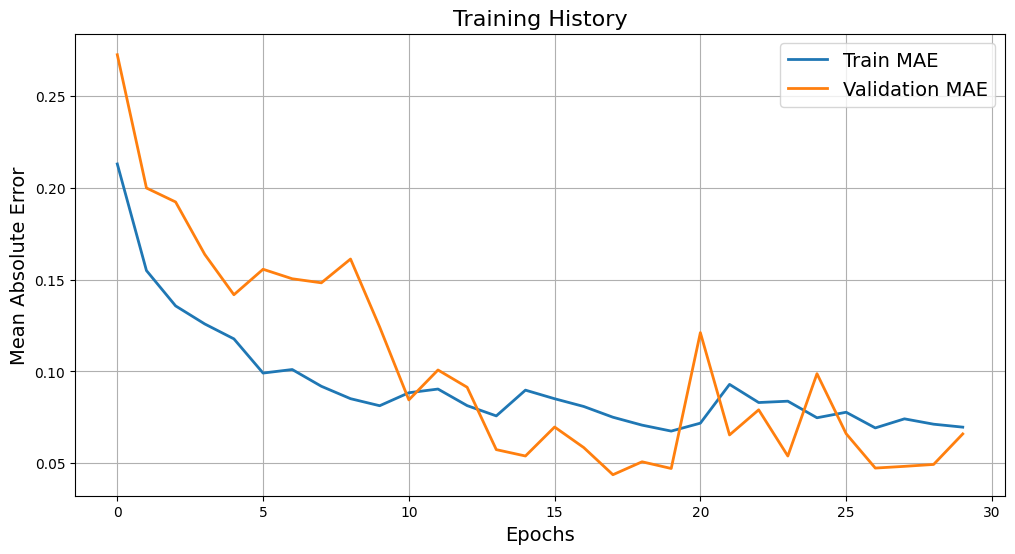

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


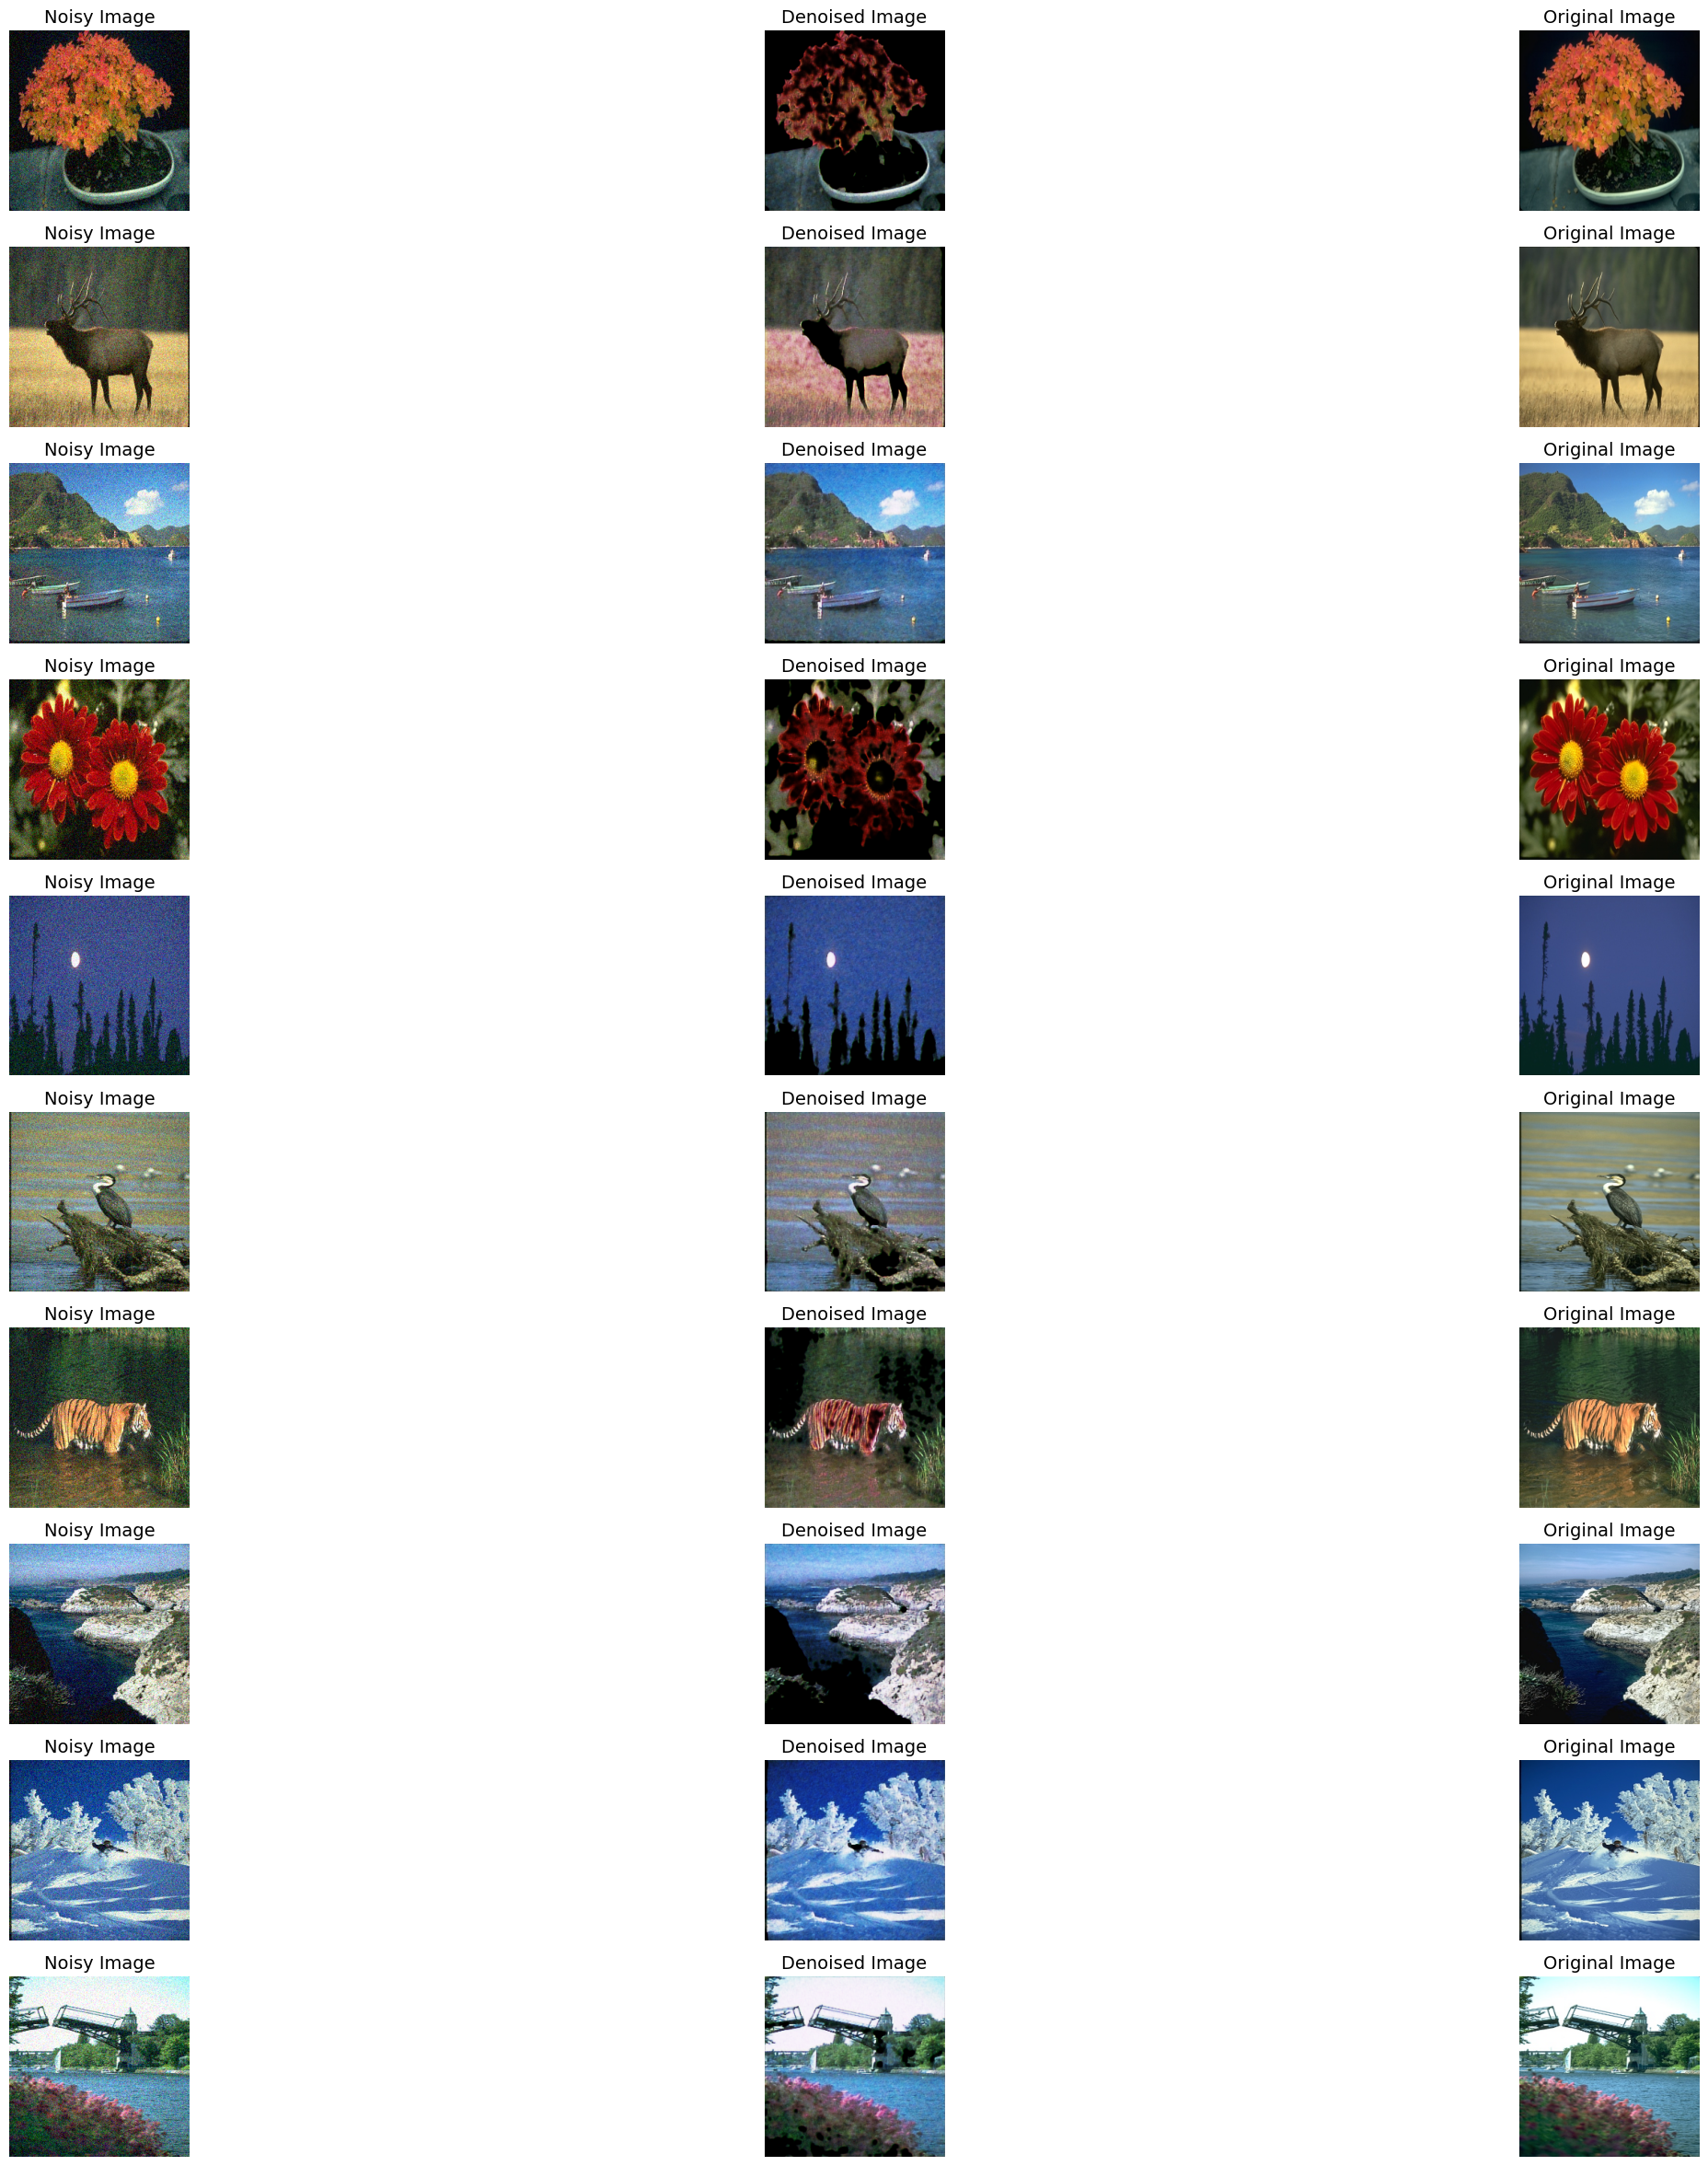

Model saved at /content/drive/MyDrive/saved_model.h5.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
import time # Import the time module

# Attempt to mount the drive. This will prompt you to re-authenticate if needed.
try:
    drive.mount('/content/drive', force_remount=True) # Use force_remount to ensure a fresh mount
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please try re-running the cell to re-authenticate.")


# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

class ImageDenoiser:
    def __init__(self, image_size=(256, 256, 3), num_layers=20, filters=64):
        self.image_size = image_size
        self.num_layers = num_layers
        self.filters = filters
        self.model = self.build_model()
        print("Model initialized.")

    def build_model(self):
        inputs = keras.Input(shape=self.image_size)
        x = Conv2D(self.filters, (3, 3), padding='same')(inputs)
        x = LeakyReLU(alpha=0.1)(x)

        for _ in range(self.num_layers - 2):
            residual = x
            x = Conv2D(self.filters, (3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = Dropout(0.2)(x)
            x = Add()([x, residual])

        outputs = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
        model = keras.Model(inputs, outputs)
        model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mean_absolute_error'])
        print("Model built successfully.")
        return model

    def add_noise(self, images, noise_factor=0.1):
        gaussian_noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
        poisson_noise = noise_factor * np.random.poisson(lam=0.1, size=images.shape) / 255.0
        noisy_images = images + gaussian_noise + poisson_noise
        return np.clip(noisy_images, 0.0, 1.0).astype(np.float32)

    def load_dataset(self, dataset_path, test_size=0.1):
        images = []
        # Add a check to see if the directory exists
        if not os.path.isdir(dataset_path):
            raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")

        # You could optionally add a small delay here if the issue is timing-related after mounting
        # time.sleep(2)

        print(f"Loading images from: {dataset_path}") # Add a print statement to confirm path
        for file in os.listdir(dataset_path):
            img_path = os.path.join(dataset_path, file)
            # Check if the path is a file before reading
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (self.image_size[0], self.image_size[1]))
                    img = img.astype(np.float32) / 255.0
                    images.append(img)
                else:
                    print(f"Warning: Could not read image file {img_path}") # Warn about unreadable files
            else:
                print(f"Skipping non-file entry: {img_path}") # Inform about skipping directories/other entries

        if len(images) == 0:
            raise ValueError("No valid image files found in the dataset directory.")

        images = np.array(images).astype(np.float32)
        noisy_images = self.add_noise(images)
        return train_test_split(noisy_images, images, test_size=test_size, random_state=42)

    def train(self, dataset_path, epochs=20, batch_size=4, save_path=None):
        X_train, X_test, Y_train, Y_test = self.load_dataset(dataset_path)
        print("Starting training...")
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
        print("Training completed.")
        self.plot_training_history(history)
        self.plot_denoised_samples(X_test, Y_test)
        if save_path:
            self.save_model(save_path)
        return history

    def save_model(self, save_path):
        # Ensure the directory for saving exists
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir, exist_ok=True)
        self.model.save(save_path)
        print(f"Model saved at {save_path}.")

    def load_model(self, load_path):
        # Ensure the model file exists before loading
        if not os.path.exists(load_path):
             raise FileNotFoundError(f"Model file not found at {load_path}")
        self.model = keras.models.load_model(load_path, compile=True)
        print(f"Model loaded from {load_path}.")

    def plot_training_history(self, history):
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['mean_absolute_error'], label='Train MAE', linewidth=2)
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', linewidth=2)
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Mean Absolute Error", fontsize=14)
        plt.legend(fontsize=14)
        plt.title("Training History", fontsize=16)
        plt.grid(True)
        plt.show()

    def plot_denoised_samples(self, noisy_images, original_images, num_samples=35):
        fig, axes = plt.subplots(num_samples, 3, figsize=(30, 30))
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        for i in range(num_samples):
            denoised_image = self.denoise_image(noisy_images[i])

            axes[i, 0].imshow(np.clip(noisy_images[i], 0, 1))
            axes[i, 0].set_title("Noisy Image", fontsize=14)
            axes[i, 1].imshow(np.clip(denoised_image, 0, 1))
            axes[i, 1].set_title("Denoised Image", fontsize=14)
            axes[i, 2].imshow(np.clip(original_images[i], 0, 1))
            axes[i, 2].set_title("Original Image", fontsize=14)
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
            axes[i, 2].axis('off')
        plt.show()

    def denoise_image(self, noisy_image):
        denoised = self.model.predict(np.expand_dims(noisy_image, axis=0))
        denoised = np.clip(denoised[0], 0, 1).astype(np.float32)
        return denoised

# Define paths
dataset_path = '/content/drive/MyDrive/train'
save_model_path = '/content/drive/MyDrive/saved_model.h5'

# Initialize and train
denoiser = ImageDenoiser()
history = denoiser.train(dataset_path, epochs=30, batch_size=4, save_path=save_model_path)